In [1]:
__author__ = 'Stephanie Juneau, NOAO Data Lab Team'
__version__ = '20180104' # yyyymmdd
__datasets__ = ['ls_dr3']

# Star/Galaxy/QSO Classification in the DESI Imaging Legacy Surveys
by Stéphanie Juneau, Robert Nikutta, Knut Olsen and the NOAO Data Lab Team

In this notebook, we investigate the optical and infrared colors of astronomical sources detected in the DECam Legacy Survey (DECaLS). The third data release of this imaging survey comprises ~400 millions stars, galaxies and quasars (or QSOs: Quasi-Stellar Objects). 

NOAO Data Lab products and services used here:
<ul>
<li>the Legacy Survey (LS) DR3 database</li>
<li>Jupyter Notebook Server</li>
<li>Query Manager</li>
<li>Image cutout tool similar to Data Lab SIA</li>
</ul>

Below, we query the database, compute colors, plot a few color combinations, and take into account the source "type" as defined from the light profile shape in order to differentiate between object classes.

### Table of contents
* [0. Disclaimer & attribution](#attribution)
* [1. Introduction](#introduction)
* [2. Imports & setup](#import)
* [3. Authentication](#auth)
* [4. Query DECaLS Tractor Photometry Catalog](#query)
* [5. Plot Results](#plots)
* [6. Full Size LS DR3 Query](#fullsize)
* [7. User Contributions](#users)
* [8. Image Cutouts for Subsets of Objects](#cutouts)

<a class="anchor" id="attribution"></a>
# 0. Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="introduction"></a>
# 1. Introduction

*Ellipticals are red; Spirals are blue.*

An imaging survey includes a zoo of different astronomical objects. There are foreground stars from our own Milky Way galaxies, and background galaxies at various distances, including QSOs with actively accreting supermassive black holes.

<figure>
<img src="DECaLS_noLabels.jpg", align="center", width=700>
<figcaption>**Figure 1.** Small section of the DECaLS DR3 image from the Legacy Survey [viewer](http://legacysurvey.org/viewer) around RA=253.3, Dec=29.2 degrees.</figcaption>
</figure>


In preparation for DESI ([Dark Energy Spectroscopic Experiment](http://desi.lbl.gov)), the imaging Legacy Survey (including DECaLS) will be used to select over 30 million targets for the spectroscopy campain. The main DESI sample will comprise emission-line galaxies (ELGs), luminous red galaxies (LRGs), and QSOs. There will also be a Bright Galaxy Survey (BGS) targetting a magnitude-limited sample (r<19.5), including stars within the Milky Way.

<figure>
<img src="DECaLS_Labels.jpg", align="center", width=700>
<figcaption>**Figure 2.** Same section of the DECaLS DR3 image as in Figure 1 but with labels from a preliminary target selection algorithm (applied to DR2 observations).</figcaption>
</figure>

## 1.1 Information about DECaLS
DECaLS will cover ~9500 deg² in the g, r, z bands to depths of g=24.7, r=23.9, z=23.0. Infrared WISE data are also extracted at the location of the DECaLS sources.

The third data release (DR3) includes a portion of DECaLS, covering a disjoint footprint with 4300 deg² in g-band, 4600 deg² in r-band and 8100 deg² in z-band, of which 4200 deg² has been observed in all three optical filters.

You can read more about DECaLS on the Data Lab survey page [(here)](http://datalab.noao.edu/decals/ls.php) and on the Legacy Survey team website [(here)](http://legacysurvey.org). The fourth data release (DR4) includes data from MzLS and BASS, covering the northern portion of the Legacy Survey imaging footprint. The fifth data release (DR5) largely supersedes DR3, including only DECaLS observations, and as described in this [NOAO Currents Article](https://www.noao.edu/currents/201710.html#lsdr5).

## 1.2 Magnitudes and Colors

Magnitudes are obtained through a set of filters similar to the *u,g,r,i,z* set used for SDSS. In this work, we use:
<ul>
<li>*g,r,z* from the Dark Energy Camera (DECam)
<li>*W1, W2* forced photometry in [WISE](http://www.nasa.gov/mission_pages/WISE/main/) channels 1 & 2 (3.4 and 4.6 microns)
</ul>

Colors are defined as a difference between magnitudes in two bands. A "redder" color means that the object is comparatively brighter in the redder (i.e., longer wavelength) band. Conversely, a "bluer" color means that the object is comparatively brighter in the bluer (i.e., shorter wavelength) band. 

We will use the following colors: 
<ul>
<li>*g-r*
<li>*r-z*
<li>*z-W1*
<li>*W1-W2*
</ul>

## 1.3 Object Shapes/Types

The object shape (2D light profile) is modeled by [the Tractor](http://thetractor.org) ([Lang, Hogg & Mykytyn](http://adsabs.harvard.edu/abs/2016ascl.soft04008L)) as part of the procedure to compute model photometry.

Possible shapes for DECaLS DR3:
<ul>
<li>PSF (point spread function: size will vary with the seeing of the observations)</li>
<li>SIMP (“simple” galaxies: round, exponential profile with 0.45″ effective radius)</li>
<li>EXP (exponential profile; spiral galaxies)</li>
<li>DEV (deVaucouleurs profile; elliptical galaxies)</li>
<li>COMP (composite deVaucouleurs+exponential at same centroid)</li>
</ul>

<figure>
<img src="Gals_Qso.jpg", align="left", width=600>
<figcaption>**Figure 3.** Images of galaxies including a nearby elliptical galaxy, a nearby spiral galaxy, and a QSO.</figcaption>
</figure>

Summary of shape fitting and assignment:
<ol>
<li>Fit all sources with PSF and SIMP; keep if significant (5 sigma); otherwise discard.
<li>If SIMP is better model, fit again with EXP and DEV; keep if 3 sigma improvement
<li>Fit again with COMP (composite of EXP and DEV); keep if further 3 sigma improvement
</ol>

Please note that after DR3, the **SIMP** model is replaced with **REX** (Round Exponential).

<a class="anchor" id="import"></a>
# 2. Import

In [2]:
# Python 2/3 compatibility
from __future__ import print_function # to use print() as a function in Python 2

try:
    input = raw_input # use 'input' function in both Python 2 and 3
except NameError:
    pass

# std lib
from astropy.table import Table

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, helpers
print('Done importing')

Done importing


<a class="anchor" id="auth"></a>
# 3. Authenticate

In [3]:
# To save to virtual space, you need to log in your account (not anonymous)
token = ac.login('anonymous')
print('Done getting token')

Done getting token


<a class="anchor" id="query"></a>
# 4. Query DECaLS Tractor Photometry Catalog

The photometry is derived from Tractor modeling of sources, and the database includes model photometry, type (shape), as well as aperture photometry in various aperture sizes. In this work, we will use Tractor model magnitudes.

The database is called **ls_dr3** and includes several tables. We will use the **tractor_primary** table, selected to contain primary objects. The column names and descriptions can be found from the [Data Lab Query Interface](http://datalab.noao.edu/query.php) or using the Table Access Protocol (TAP) service with, e.g., TOPCAT. In both cases, we are interested in **ls_dr3.tractor_primary**.

In [4]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT dered_mag_g as gmag, dered_mag_r as rmag, dered_mag_z as zmag, 
               dered_mag_w1 as w1mag, dered_mag_w2 as w2mag, type,
               snr_g, snr_r, snr_z, snr_w1, ra, dec 
        FROM ls_dr3.tractor_primary
        WHERE (snr_g>3 and snr_r>3 and snr_z>3)
        LIMIT 400000"""
 
# dered_mag_g,r,z  = AB magnitudes in DECam g,r,z bands corrected for Galactic reddening
# dered_mag_w1,w2  = AB magnitudes in WISE bands W1 & W2 corrected for Galactic reddening
# type             = object type (PSF, SIMP, EXP, DEV, COMP)
# snr_g,r,z        = pre-computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec           = celestial coordinates
#
# WHERE: requirement that S/N>3 in each DECaLS band
# LIMIT: returns 200,000 rows that satisfy the query

print(query)


        SELECT dered_mag_g as gmag, dered_mag_r as rmag, dered_mag_z as zmag, 
               dered_mag_w1 as w1mag, dered_mag_w2 as w2mag, type,
               snr_g, snr_r, snr_z, snr_w1, ra, dec 
        FROM ls_dr3.tractor_primary
        WHERE (snr_g>3 and snr_r>3 and snr_z>3)
        LIMIT 400000


In [5]:
%%time
# Execute the Query synchronously if short (e.g., LIMIT<=400,000)
response = qc.query(token, sql=query, fmt='csv')

print('Time')

Time
CPU times: user 433 ms, sys: 157 ms, total: 590 ms
Wall time: 5.58 s


In [6]:
# Reformat output into a table
#result = Table.read(StringIO(response), format='csv')  #dictionary
# Reformat output into a Pandas Data Frame
result = helpers.convert(response,'pandas')

# Print a few rows from the result table
print(result[:5])
len(result)

Returning Pandas dataframe
      gmag     rmag     zmag    w1mag    w2mag  type     snr_g      snr_r  \
0  23.6130  22.8649  22.2655      NaN      NaN  SIMP    6.2101    9.64925   
1  22.8437  21.2729  19.3515  19.9105  20.1947   PSF   14.9215   48.13690   
2  21.5455  20.5946  19.9088  19.7712  20.3009  SIMP   38.1031   69.57190   
3  22.0519  21.0189  20.1874  19.3117  19.9200   EXP   21.7362   42.55000   
4  18.1704  17.6686  17.4671  18.9581  19.6465   PSF  419.3400  560.44600   

       snr_z     snr_w1          ra       dec  
0    6.74185  -0.190781  328.013198 -2.547834  
1  124.19100  11.376600  328.012088 -2.545648  
2   57.34310  12.520300  328.006297 -2.538477  
3   29.83360  18.930600  328.021637 -2.558729  
4  421.46600  27.492700  328.023623 -2.560929  


400000

<a class="anchor" id="plots"></a>
# 5. Plot Results

## 5.1 Optical Color-Color Diagram



In [7]:
# Select range of interest
thres = 5.   #threshold value for S/N (here, making it more stringent than query)
keep = (result['snr_g']>thres)&(result['snr_r']>thres)&(result['snr_z']>thres)

# Colors
g_r   = result['gmag'][keep] - result['rmag'][keep]
r_z   = result['rmag'][keep] - result['zmag'][keep]
z_w1  = result['zmag'][keep] - result['w1mag'][keep]   # note: no constraint on S/N(W1)

len(g_r)

# Classification per object type
objtype = result['type'][keep]

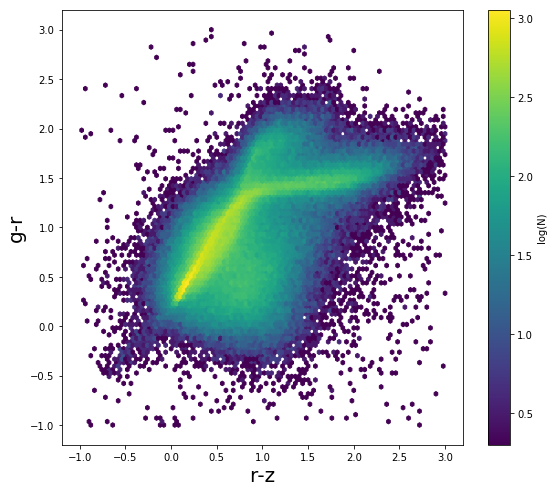

In [8]:
col0 = r_z   #r-z color
col1 = g_r   #g-r color

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
ax1.set_xlabel('r-z',fontsize=20)
ax1.set_ylabel('g-r',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

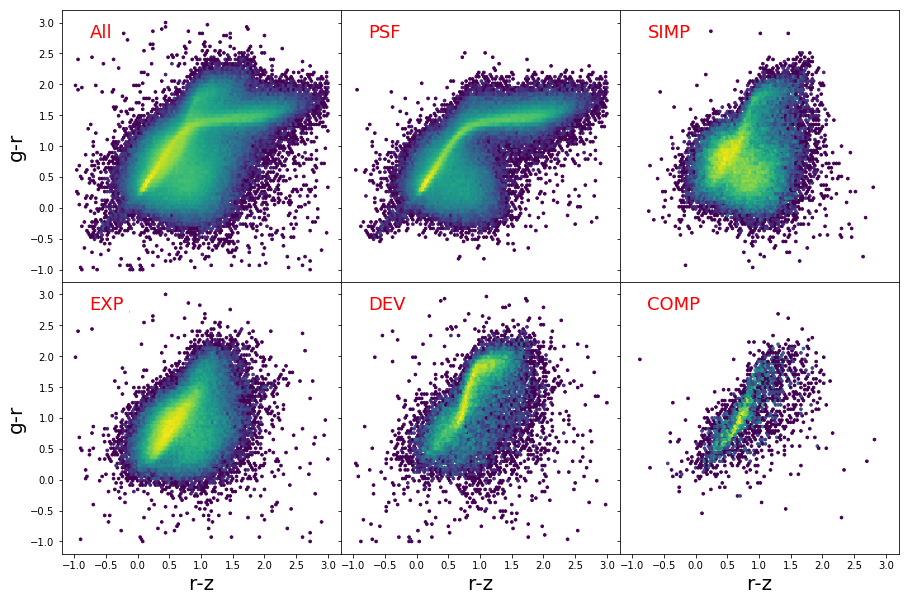

In [9]:
col0 = r_z   #r-z color
col1 = g_r   #g-r color

# List of the types
typeList = ['All','PSF','SIMP','EXP','DEV','COMP']

# Define figure to have 6 panels: 2 rows X 3 columns (with shared axes)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()   # flatten axes object to be able to loop over it

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(col0),dtype='bool')   #for All objects: array of 1's
    else:
        selec = (objtype==typ)    #for each type, select on the type parameter
    # 2D-histogram of objects with hexagonal bins
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
    if i>=3: ax.set_xlabel('r-z',fontsize=20)   #only label x axis for second (last) row
    if i%3==0: ax.set_ylabel('g-r',fontsize=20) #only label y axis for first column
    # Label the type on each panel (red font over white background)
    ax.text(0.1,0.9,typ,transform=ax.transAxes,fontsize=18,color='red',backgroundcolor='white')

plt.subplots_adjust(wspace=0., hspace=0.)

plt.show()

## 5.2 Optical-Infrared Colors

Combine information from optical/near-infrared DECam observations and from WISE mid-infrared observations. The latter were extracted using "forced photometry" at the position of DECaLS objects.

In [10]:
# Select range of interest
thres = 5.   #threshold value for S/N (here, making it more stringent than query)
keepIr = (result['snr_g']>thres)&(result['snr_r']>thres)&(result['snr_z']>thres)&(result['snr_w1']>thres)

# Constraint on S/N(W1) but not S/N(W2) [won't be used as much below]
g_r_ir   = result['gmag'][keepIr] - result['rmag'][keepIr]
z_w1_ir  = result['zmag'][keepIr] - result['w1mag'][keepIr]
w1_w2_ir = result['w1mag'][keepIr] - result['w2mag'][keepIr]

# Classification per object type
objtype_ir = result['type'][keepIr]

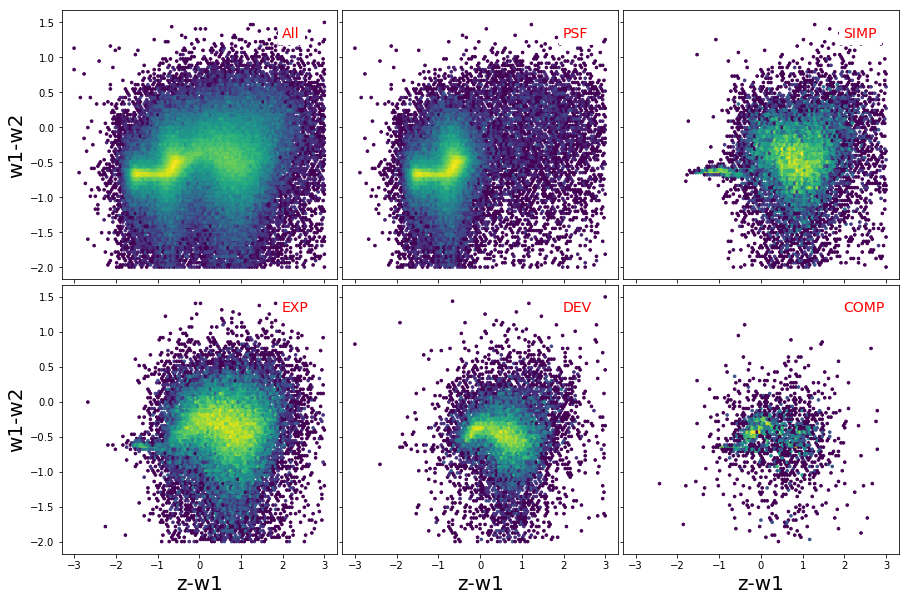

In [11]:
# First, try z-W1 versus infrared color W1-W2
col0 = z_w1_ir
col1 = w1_w2_ir

# List
typeList = ['All','PSF','SIMP','EXP','DEV','COMP']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(objtype_ir),dtype='bool')
    else:
        selec = (objtype_ir==typ)
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-3, 3, -2., 1.5))
    if i>=3: ax.set_xlabel('z-w1',fontsize=20)
    if i%3==0: ax.set_ylabel('w1-w2',fontsize=20)
    ax.text(0.8,0.9,typ,transform=ax.transAxes,fontsize=14,color='red',backgroundcolor='white')

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

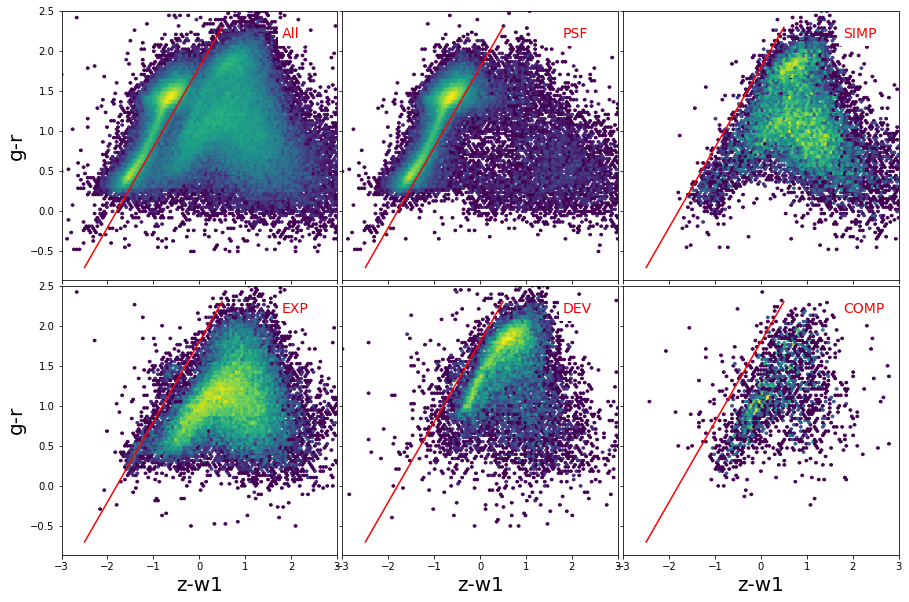

In [12]:
keepIr = (result['snr_g']>thres)&(result['snr_r']>thres)&(result['snr_z']>thres)&(result['snr_w1']>thres)

# Combine g-r with z-W1 color (latter has more separation power than W1-W2)
col0 = z_w1_ir
col1 = g_r_ir

# List
typeList = ['All','PSF','SIMP','EXP','DEV','COMP']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()

x = np.arange(4)-2.5

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(objtype_ir),dtype='bool')
    else:
        selec = (objtype_ir==typ)
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-3, 3, -0.5, 2.5))
    if i>=3: ax.set_xlabel('z-w1',fontsize=20)
    if i%3==0: ax.set_ylabel('g-r',fontsize=20)
    ax.text(0.8,0.9,typ,transform=ax.transAxes,fontsize=14,color='red',backgroundcolor='white')
    ax.plot(x, 1.0*x+1.8, '-',color='red')

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

<a class="anchor" id="fullsize"></a>
# 6. Full Size LS DR3 Query

Below is the result from the query *without* a LIMIT statement made directly to the database (it takes an hour to return the full result with over 151 million rows). The query is as above:

query = """
        SELECT dered_mag_g as gmag, dered_mag_r as rmag, dered_mag_z as zmag, 
               dered_mag_w1 as w1mag, dered_mag_w2 as w2mag, type,
               snr_g, snr_r, snr_z, ra, dec 
        FROM ls_dr3.tractor_primary
        WHERE (snr_g>3 and snr_r>3 and snr_z>3)"""
        
For the first plot, we require a threshold **S/N>10 for z, W1, W2**. The result is shown for 15 million objects satisfying these criteria (out of 151 millions). 
<figure>
<img src="grzw1_sn10_15M.jpg", align="center", width=800>
<figcaption>**Figure:** Optical-Infrared Color-Color diagram showing million objects with S/N>10 in z, W1, W2 (in addition to the requirement that S/N>3 for g, r). </figcaption>
</figure>
 
Next, we request that **S/N>3 in z, W1 & W2 but S/N$<$10 in at least one band**. This new condition is met for 29 million objects, which we show below.

<figure>
<img src="grzw1_3sn10_29M.jpg", align="center", width=800>
<figcaption>**Figure:** Optical-Infrared Color-Color diagram showing million objects with S/N>10 in z, W1, W2 (in addition to the requirement that S/N>3 for g, r). The vertical plotting range extends down to -1 (whereas it was set to -0.5 in the previous figure). </figcaption>
</figure>

The top figure with a strict quality requirement (S/N>10) shows well defined features such as branches and ridges in the color-color planes. However, the bivariate distributions are more blurry in the bottom figure. 

<a class="anchor" id="users"></a>
# 7. User Contributions

Inpired from this notebook, a few users have pushed the analysis further. Below, we will show two such contributions by graduate students during Hack sessions. First, here is an example of work with multi-epoch photometry by Dustin Lang.

## 7.1 Adding variability information
Photometry variability can add information given that QSOs, galaxies and stars have different behavior. Starting with DR5, the Legacy Surveys (LS) will include a catalog with multi-epoch photometry.

For now, images from DECam in the NOAO archive can be extracted in fields with repeat observations such as DES Supernova fields overlapping with DECaLS.

<figure>
<img src="time_series_2a.png", align="center", width=800>
<figcaption>**Figure:** Magnitudes in three bands as a function of time for a known SDSS quasar. Courtesy of Dustin Lang (Univ. of Toronto).  </figcaption>
</figure>

## 7.2 Adding spectroscopic information from SDSS
There is a Legacy Survey DR3 catalog pre-matched to SDSS DR13 spectroscopy [ls_dr3.dr3_specobj_dr13](http://datalab.noao.edu/tutdev/query.php?name=ls_dr3.dr3_specobj_dr13). One can execute a joint query by joining on "specobjid" with SDSS DR13 [(sdss_dr13.specobj)](http://datalab.noao.edu/tutdev/query.php?name=sdss_dr13.specobj). Bela Abolfathi (UC Irvine) started this work as part of a Hack Session with LSSTC Data Science Fellowship.


<figure>
<img src="hack1.jpg", align="center", width=900>
<figcaption>**Figure:** Color-color diagrams of DECaLS photometry split by SDSS spectral classes. Slightly modified version of figure by Bela Abolfathi (UC Irvine). </figcaption>
</figure>


## 7.3 Machine Learning application

A training set was built using DECaLS DR3 photometry and SDSS (DR13 & DR12Q) classifications. This preliminary work was done by Jan-Torge Schindler (Univ. of Arizona). Updates could include using more parameters beyond photometry (e.g., type, chi^2).

<figure>
<img src="hack2.jpg", align="center", width=500>
<figcaption>**Figure:** Confusion Matrix comparing true classification from SDSS and the result from the Random Forest classification. Courtesy of JT Schindler (Univ. of Arizona). </figcaption>
</figure>

For an example application of Random Forest for Star/Galaxy classification applied to the Palomar Transient Factory (PTF) survey, see [Miller et al (2017)](http://adsabs.harvard.edu/abs/2017AJ....153...73M).

<a class="anchor" id="cutouts"></a>
# 8. Image Cutouts for Subsets of Objects

The NOAO Data Lab has developed a Simple Image Access (SIA) tool, which returns the list of possible images given a location (RA, Dec). Below, we use an image cutout service at NERSC to retrieve g,r,z and W1,W2 color jpeg images.

We will get imagse for objects with "type=PSF", and randomly select six with a blue *z-W1* color expected for the stellar locus, and six with a red *z-W1* color corresponding the cloud of points to the right-hand side of the color-color diagrams from Section 5.2. 

## 8.1 Select Subsets and Define Variables

In [23]:
# Properties for selecting subsamples of interest
objtype = result['type'][keepIr].values    # ".values" convert to numpy array
col1 = z_w1_ir.values
w1   = result['w1mag'][keepIr].values
zmag = result['zmag'][keepIr].values

# Select interesting subset of points
selec = (objtype=='PSF')&(w1>18)&(w1<19.5) # Point source (type=PSF) & bright W1 (18 < W1[AB] < 19.5)
red   = (col1>1)&(col1<2)                  # red side: 1 < z-W1 < 2
blue  = (col1>-0.8)&(col1<-0.5)            # blue side: -0.8 < z-W1 < -0.5

# Retrieve by position (RA, Dec)
ra  = result['ra'][keepIr].values
dec = result['dec'][keepIr].values

idx = np.arange(ra.size)

# Indices fulfilling both criteria
psf_red = idx[selec&red]
psf_blue = idx[selec&blue]

# Random selection
selec_blue = np.random.choice(psf_blue,6,replace=False)
selec_red  = np.random.choice(psf_red,6,replace=False)

# Define RA, Dec on blue & red z-W1 sides
ra_blue  = ra[selec_blue]
dec_blue = dec[selec_blue]
ra_red  = ra[selec_red]
dec_red = dec[selec_red]

# Define z & W1 magnitudes on blue & red z-W1 sides
zmag_blue = zmag[selec_blue]
w1_blue   = w1[selec_blue]
zmag_red  = zmag[selec_red]
w1_red    = w1[selec_red]

## 8.2 Function to Retrieve Cutouts

In [24]:
def make_cutout_comparison_table(ra_in, dec_in):
    """
    Obtain DECaLS and WISE color JPEG images from Legacy Survey team cutout tool at NERSC
    """    
    de_img = []
    wi_img = []
    
    for i in range(len(ra_in)):
        de_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=decals-dr3&zoom=15&bands=grz' % (ra_in[i],dec_in[i])
        img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
        de_img.append(img)
        
        wi_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=unwise-w1w2&zoom=15' % (ra_in[i],dec_in[i])
        img = plt.imread(download_file(wi_cutout_url,cache=True,show_progress=False,timeout=120))
        wi_img.append(img)

    return de_img,wi_img

## 8.3 Function to Generate Plots

In [25]:
def plot_de_wi(de_img,wi_img,zmag,w1mag):
    """
    Plot images in two rows with 6 images in each row (Top: DECaLS grz; Bottom: WISE W1/W2)
    Label the z band mag on the top images; Label the W1 mag on the bottom images
    """
    fig = plt.figure(figsize=(12,4))

    for i in range(len(de_img)):
        ax = fig.add_subplot(2,6,i+1)
        ax.imshow(de_img[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.1,0.9,'z=%.1f'%zmag[i],transform=ax.transAxes,fontsize=12,color='white')

        ax = fig.add_subplot(2,6,i+7)
        ax.imshow(wi_img[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.1,0.9,'W1=%.1f'%w1mag[i],transform=ax.transAxes,fontsize=12,color='white')

    plt.subplots_adjust(wspace=0.02, hspace=0.03)


## 8.4 Montage for "Blue" z-W1

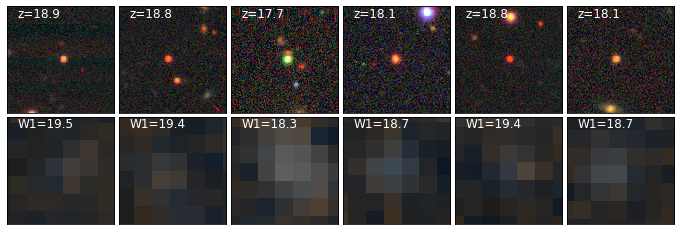

In [26]:
# Plot images of randomly selected targets best fit with a PSF profile
# from the "blue" z-W1 side, with -0.8 < z-W1 < -0.5
de_img,wi_img = make_cutout_comparison_table(ra_blue,dec_blue)
plot_de_wi(de_img,wi_img,zmag_blue,w1_blue)

## 8.5 Montage for "Red" z-W1


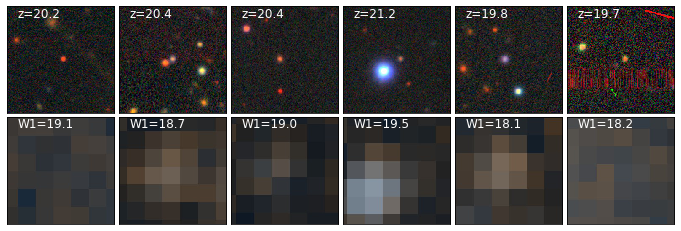

In [27]:
# Plot images of randomly selected targets best fit with a PSF profile 
# from the "red" z-W1 side, with 1 < z-W1 < 2
de_img,wi_img = make_cutout_comparison_table(ra_red,dec_red)
plot_de_wi(de_img,wi_img,zmag_red,w1_red)